In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym

In [2]:
from amalearn.environment import MutliArmedBanditEnvironment
from amalearn.environment import EnvironmentBase
from amalearn.reward import GaussianReward
from amalearn.agent import RandomBanditAgent
from amalearn.agent import AgentBase

## Utils

In [3]:
def calculate_regret(rewards, Optimal_action_reward):
    regrets = [0]
    for i in range(len(rewards)):
        regrets.append(regrets[i] + abs(rewards[i] - Optimal_action_reward))
    return regrets

In [4]:
def calculate_optimal_action_percentage(chosen_actions, Optimal_action, window = 20):
    result = []
    for i in range(len(chosen_actions) - window):
        result.append(chosen_actions[i:i+window].count(Optimal_action)/window*100)
    return result

In [5]:
def calculate_avg_reward(rewards, window = 40):
    result = []
    for i in range(len(rewards) - window):
        result.append(np.array(rewards[i:i+window]).mean())
    return result

In [6]:
def hemographic_learning_rate(x):
    return 100/(7*x+300)

Text(0.5, 1.0, 'Learning rate')

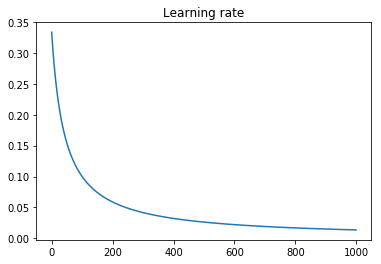

In [7]:
plt.plot(range(1000), [hemographic_learning_rate(i) for i in range(1000)])
plt.title('Learning rate')

## Class definitions

In [8]:
class myRandomAgent(AgentBase):
    def __init__(self, id, environment):
        super(myRandomAgent, self).__init__(id, environment)
    
    def take_action(self) -> (object, float, bool, object):
        available_actions = self.environment.available_actions()
        action = np.random.choice(available_actions)
        obs, r, d, i = self.environment.step(action)
        if d: print('-----Terminated-----')
        return r, d, action

In [9]:
class myThompsonBayesAgent(AgentBase):
    def __init__(self, id, environment, num_of_actions):
        super(myThompsonBayesAgent, self).__init__(id, environment)
        self.belief_mean = np.zeros(num_of_actions)
        self.belief_variance = np.ones(num_of_actions) * np.inf
        self.belief_pi = 1/self.belief_variance
        self.trial = 0
    
    def take_action(self) -> (object, float, bool, object):
        self.trial += 1

        available_actions = self.environment.available_actions()
        action_samples = \
        [np.random.normal(self.belief_mean[i], self.belief_variance[i]**(1/2), 1) for i in range(available_actions)]
        action = np.argmax(action_samples)

        obs, reward, fin, info = self.environment.step(action)

        pi_o = 0.15
        learning_rate = hemographic_learning_rate(self.trial)
        self.belief_mean[action] = \
        self.belief_mean[action] + learning_rate * (reward - self.belief_mean[action])
        self.belief_pi[action] = self.belief_pi[action] + pi_o
        self.belief_variance[action] = 1 / self.belief_pi[action]
        
        if fin: print('-----Terminated-----')
        return reward, fin, action

## Question #1 reward distribution

Initialization of rewards

In [10]:
means = np.random.normal(0, 1, 10)
stds = np.ones(10)

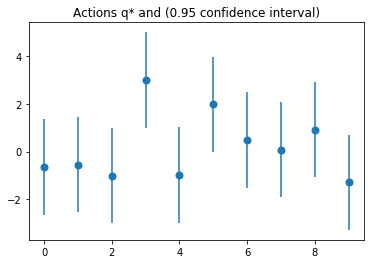

In [11]:
plt.errorbar(range(10), means, 2*stds, mew=2, fmt='o')
plt.title('Actions q* and (0.95 confidence interval)')
plt.show()

In [12]:
rewards = [GaussianReward(mean, std) for mean, std in zip(means, stds)]

In [13]:
Optimal_action = np.argmax(means)
Optimal_action_reward = means[Optimal_action]
Optimal_action_reward

3.0037417982029533

### - Random Agent

In [14]:
environment = MutliArmedBanditEnvironment(rewards, 1000, '1')
randomAgent = myRandomAgent('2', environment)

In [15]:
result_random_agent = []
for step in range(1000):
    result_random_agent.append(randomAgent.take_action())

-----Terminated-----


In [16]:
chosen_actions_r = [i[2] for i in result_random_agent]
rewards_actions_r = [i[0] for i in result_random_agent]
regrets_r = calculate_regret(rewards_actions_r, Optimal_action_reward)
optimal_percentage_r = calculate_optimal_action_percentage(chosen_actions_r, Optimal_action, 100)
avg_rewards_r = calculate_avg_reward(rewards_actions_r, 100)

### - Thompson-Bayes Agent

In [17]:
environment = MutliArmedBanditEnvironment(rewards, 1000, '1')
agent = myThompsonBayesAgent('1', environment, 10)

In [18]:
result_myThompsonBayes_agent = []
for step in range(1000):
    result_myThompsonBayes_agent.append(agent.take_action())

-----Terminated-----


In [30]:
chosen_actions_t = [i[2] for i in result_myThompsonBayes_agent]
rewards_actions_t = [i[0] for i in result_myThompsonBayes_agent]
regrets_t = calculate_regret(rewards_actions_t, Optimal_action_reward)
optimal_percentage_t = calculate_optimal_action_percentage(chosen_actions_t, Optimal_action, 100)
avg_rewards_t = calculate_avg_reward(rewards_actions_t, 100)

### - Comparison and Metrics

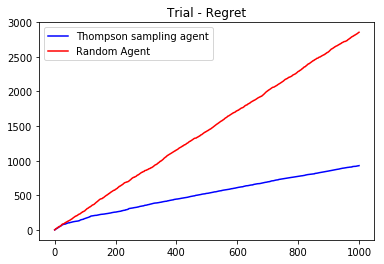

In [20]:
plt.plot(range(len(regrets_t)), regrets_t, "-b", label="Thompson sampling agent")
plt.plot(range(len(regrets_r)), regrets_r, "-r", label="Random Agent")
plt.title('Trial - Regret')
plt.legend(loc="upper left")
plt.show()

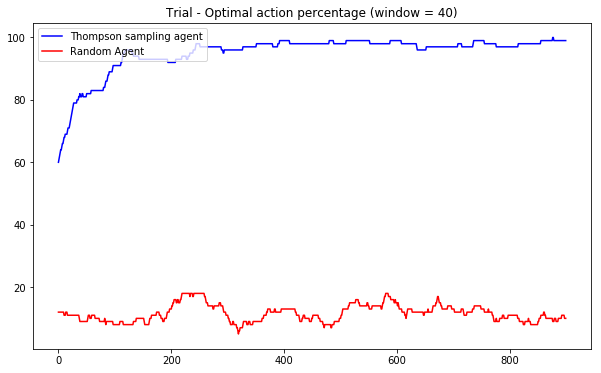

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(optimal_percentage_t)), optimal_percentage_t, "-b", label="Thompson sampling agent")
plt.plot(range(len(optimal_percentage_r)), optimal_percentage_r, "-r", label="Random Agent")
plt.title('Trial - Optimal action percentage (window = 40)')
plt.legend(loc="upper left")
plt.show()

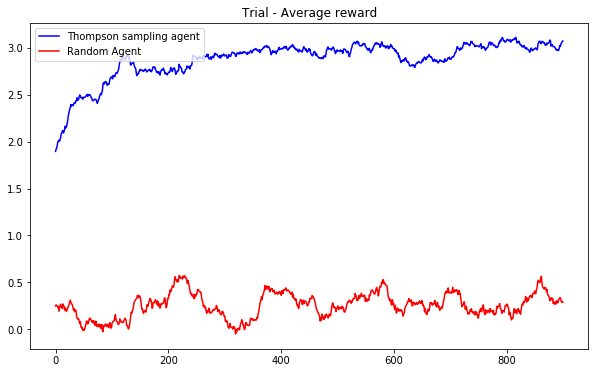

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(avg_rewards_t)), avg_rewards_t, "-b", label="Thompson sampling agent")
plt.plot(range(len(avg_rewards_r)), avg_rewards_r, "-r", label="Random Agent")
plt.title('Trial - Average reward')
plt.legend(loc="upper left")
plt.show()

### Thompson sampling in 20 iterations

In [23]:
def run_thompson_once():
    rewards = [GaussianReward(mean, std) for mean, std in zip(means, stds)]
    environment = MutliArmedBanditEnvironment(rewards, 1000, '1')
    agent = myThompsonBayesAgent('1', environment, 10)
    result_myThompsonBayes_agent = []
    for step in range(1000):
        result_myThompsonBayes_agent.append(agent.take_action())
    chosen_actions_t = [i[2] for i in result_myThompsonBayes_agent]
    rewards_actions_t = [i[0] for i in result_myThompsonBayes_agent]
    return chosen_actions_t, rewards_actions_t

In [24]:
actions_20 = []
rewards_20 = []
for i in range(20):
    actions, rewards = run_thompson_once()
    actions_20.append(actions)
    rewards_20.append(rewards)
mean_reward = [np.array([j[i] for i in range(20)]).mean() for j in np.array(rewards_20).T]

optimal_action_percentage_20 = \
[calculate_optimal_action_percentage(i, Optimal_action, 40) for i in actions_20]

mean_optimal_action_percentage = \
[np.array([j[i] for i in range(20)]).mean() for j in np.array(optimal_action_percentage_20).T]


-----Terminated-----
-----Terminated-----
-----Terminated-----
-----Terminated-----
-----Terminated-----
-----Terminated-----
-----Terminated-----
-----Terminated-----
-----Terminated-----
-----Terminated-----
-----Terminated-----
-----Terminated-----
-----Terminated-----
-----Terminated-----
-----Terminated-----
-----Terminated-----
-----Terminated-----
-----Terminated-----
-----Terminated-----
-----Terminated-----


In [25]:
regrets_t = calculate_regret(rewards_actions_t, Optimal_action_reward)
optimal_percentage_t = calculate_optimal_action_percentage(chosen_actions_t, Optimal_action, 40)
avg_rewards_t = calculate_avg_reward(rewards_actions_t, 100)

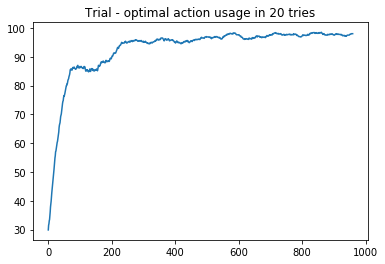

In [26]:
plt.plot(mean_optimal_action_percentage)
plt.title('Trial - optimal action usage in 20 tries')
plt.show()

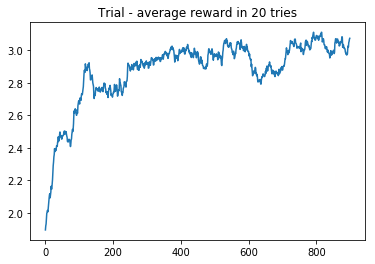

In [27]:
plt.plot(avg_rewards_t)
plt.title('Trial - average reward in 20 tries')
plt.show()